# Building a Classical Periodogram

In previous sections, we've looked at some real life time series and talked about using sinusoids as a good model to fit some time series variability. However, we came across a problem; we can't fit a period for the sinusoid model using our simple linear algebra. 

Let's come back to this idea and see what we can do.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lc = lk.search_lightcurve('Kepler-10', 
                          mission='Kepler', 
                          quarter=10, 
                          exptime=1800).download()

ConnectionError: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /portal/Mashup/Mashup.asmx/columnsconfig (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x29d2b7220>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

Above, I've downloaded data for the target "Kepler-10", which is a famous star from the Kepler mission. This star has a planet transiting around it. The time-series data here is just the brightness of the target over time. We can grab the data out of this Python object. I will use only the first 1000 elements as an example.

**Note:** `lc` is a `lightkurve` object, which you might already know how to work with. For the purposes of this tutorial, I'm just going to take the time and flux components from this object and work with them as `numpy` arrays.

In [20]:
x, y = (lc.remove_nans().time.value[:1000],
        np.asarray(lc.remove_nans().normalize().flux.value)[:1000])
x -= x.mean()

In [21]:
x[:5]

array([-10.33453882, -10.31410481, -10.29367069, -10.27323678,
       -10.25280277])

In [22]:
y[:5]

array([1.0002722, 1.0003943, 1.0003676, 1.0004128, 1.0004009],
      dtype=float32)

Now we have the array of times `x` and the array of flux values `y`. Let's plot them below.

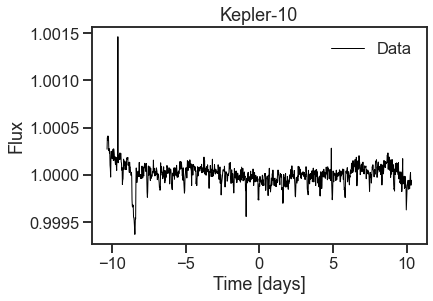

In [23]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

### Working with Sinusoids

We have some astrophysical intuition for this target that since this is a star, and stars rotate, a sinusoid model might be a reasonable one for this data.

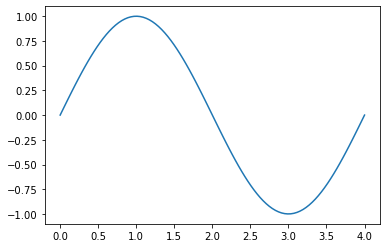

In [3]:
x = np.linspace(0, 4, 100)
period = 4
plt.plot(x, np.sin(x * (2 * np.pi)/period))

Above is the curve $sin(\frac{2x\pi}{P})$ where $P$ is the period of the curve. If we want to make a model where **$P$ is a variable** in our model, this **cannot be a linear model** because it is inside the $sin$ function. There is no way for us to tune the period $P$ in this model by multiplying by a coefficient.

Multiplying by a coefficient will only change the amplitude of the curve:

$w_0 sin(\frac{2x\pi}{P})$

So what do we do? In a case where we happen to know a period, we can use a linear model to find the best fitting amplitude of the sinusoid, but we can't use a linear model to find the best fitting period. Let's break this up, to fit a sinusoid model we're going to need to be able to fit

- The amplitude
- The period
- The phase

For **amplitude**, we can already do that, if we set up a linear model the coefficients will tune the amplitude. For phase 